In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
import numpy as np
import skimage as sk
from skimage import io
import seaborn as sns
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
from skimage import exposure

import warnings
warnings.filterwarnings("ignore")

In [3]:
def process_image(frogID,pop,minthres,maxthres):
    #Read file
    image = io.imread("".join(['sampleImages/',pop,'/',frogID,"-PD.png"]), pilmode='RGBA')
    #image = io.imread("".join(['sampleImages/',pop,'/',frogID,"-PD.png"]))
    #Correcting image
    #Double logarithmic correction of the exposure
    gamma2=exposure.adjust_log(image)
    gamma3=exposure.adjust_log(gamma2)
    #Convert to gray
    ranita0 = color.rgba2rgb(gamma3) 
    ranita = color.rgb2gray(ranita0) 
    #The transparent pixels are turned to black which is 0, we convert that into nan
    ranita[ranita == 1] = 'nan' 
    copia_ranita=ranita.copy()

    
    #Get density distribution of pixels
    x=copia_ranita.ravel()
    x =x[~np.isnan(x)]
    plot=sns.distplot(x);
    density=plot.get_lines()[0].get_data();
    plot.get_figure().clf(); 
    x1=density[0]
    y1=density[1]
    
    #Black threshold
    middle=len(x1[x1>minthres])
    maxval=len(x1[x1<maxthres])
    m=np.diff(y1)/np.diff(x1)
    num= np.argmax(m[-middle:maxval])
    cut=x1[-middle+num]

    
    #Glare control
    tail=len(x1[x1>.55])
    mintail=np.argmin(m[-tail:])
    glare=x1[-tail+mintail]
    ranita[ranita>glare] = 'nan' 
    
    #Thresholding segmentation, this value was determined by histograms
    frog_segmented= ranita>cut
    
    tmp=np.add(np.isnan(ranita),-2)
    frog=np.subtract(frog_segmented,tmp)
    
    #Get black proportion
    unique, counts = np.unique(frog, return_counts=True)
    total_pixels=counts[1]+counts[2]
    black_proportion=counts[1]/total_pixels
    
    return [gamma3,copia_ranita,frog,black_proportion,cut,density,glare]

In [15]:
'''
        
minthres=.15
maxthres=.4 
pop='ColonModified'
ranas=["CL01","CL02","CL03","CL04","CL05",
        "CL06","CL07","CL08","CL09","CL10",
       "CL11","CL13","CL14","CL15","CL16"] 

       
minthres=.2
maxthres=.45 
pop='PopaModified'
ranas=["PP01","PP02","PP03","PP04","PP05",
      "PP06","PP07","PP08","PP09","PP10",
      "PP11","PP12","PP13","PP14","PP15",
      "PP16","PP17","PP18","PP19","PP20",
      "PP21","PP22","PP23","PP24","PP25",
      "PP26","PP27","PP28","PP29","PP30","PP31"]   

 
       
minthres=0
maxthres=.35      
pop="TranquiloBayModified"       
ranas=["TB01","TB02","TB04","TB05","TB06",
       "TB07","TB09","TB10","TB11","TB12",
       "TB13","TB14","TB15","TB16","TB17",
       "TB18","TB19","TB20","TB21","TB22",
       "TB23","TB24","TB25","TB26","TB27",
       "TB28","TB29","TB30","TB31","TB32",
       "TB33","TB34","TB35","TB36"]  
       

minthres=.15
maxthres=.45         
pop="SanCristobalModified"       
ranas=["SC01","SC02","SC03","SC05","SC06",
       "SC07","SC08","SC09","SC10","SC11",
       "SC12","SC13","SC14","SC15","SC16",
       "SC20","SC21","SC22","SC23","SC24",
       "SC25","SC26"]  
       
minthres=.2
maxthres=.45 
pop='PopaModified'
ranas=["PP01","PP02","PP03","PP04","PP05",
      "PP06","PP07","PP08","PP09","PP10",
      "PP11","PP12","PP13","PP14","PP15",
      "PP16","PP17","PP18","PP19","PP20",
      "PP21","PP22","PP23","PP24","PP25",
      "PP26","PP27","PP28","PP29","PP30","PP31"]  

minthres=.2
maxthres=.32
pop='Cemetery/RedModified'
ranas=["CMR01","CMR02","CMR03","CMR04","CMR05",
       "CMR06","CMR07","CMR08","CMR09","CMR10",
       "CMR11","CMR12","CMR13","CMR14","CMR15",
       "CMR16","CMR17","CMR18","CMR19","CMR20",
       "CMR21","CMR22","CMR23","CMR24","CMR25",
       "CMR26","CMR27","CMR28","CMR29","CMR30",
       "CM_UN_01","CM_UN_02","CM_UN_03"]


minthres=.2
maxthres=.45
pop='Cemetery/YellowModified'
ranas=["CMY01","CMY02","CMY03","CMY04","CMY05",
       "CMY06","CMY07","CMY08","CMY09","CMY10",
       "CMY11","CMY12","CMY13","CMY14","CMY15",
       "CMY16","CMY17","CMY18","CMY19","CMY20",
       "CMY21","CMY22","CMY23","CMY24","CMY25",
       "CMY26","CMY27","CMY28","CMY29","CMY30"]  
       
minthres=.15
maxthres=.4 
pop='ColonModified'
ranas=["CL01","CL02","CL03","CL04","CL05",
        "CL06","CL07","CL08","CL09","CL10",
       "CL11","CL13","CL14","CL15","CL16"] 
'''                 
minthres=0
maxthres=.3      
pop="HospitalPointModified"       
ranas=["HP01","HP02","HP04","HP05","HP06",
       "HP07","HP09","HP10","HP11","HP12",
       "HP13","HP14","HP15","HP16","HP17",
       "HP18","HP19","HP20","HP21","HP22",
       "HP23","HP24","HP25","HP26","HP27",
       "HP28","HP29","HP30"] 

original=[]
processed=[]
blackProportion=[]
color_original=[]
cutoff=[]
density=[]
vglare=[]

for rana in ranas:
    (colorori,rana,frog,black,cut,kde,glare)=process_image(rana,pop,minthres,maxthres);
    original.append(rana)
    processed.append(frog)
    color_original.append(colorori)
    blackProportion.append(black)
    cutoff.append(cut)
    density.append(kde)
    vglare.append(glare)

<Figure size 432x288 with 0 Axes>

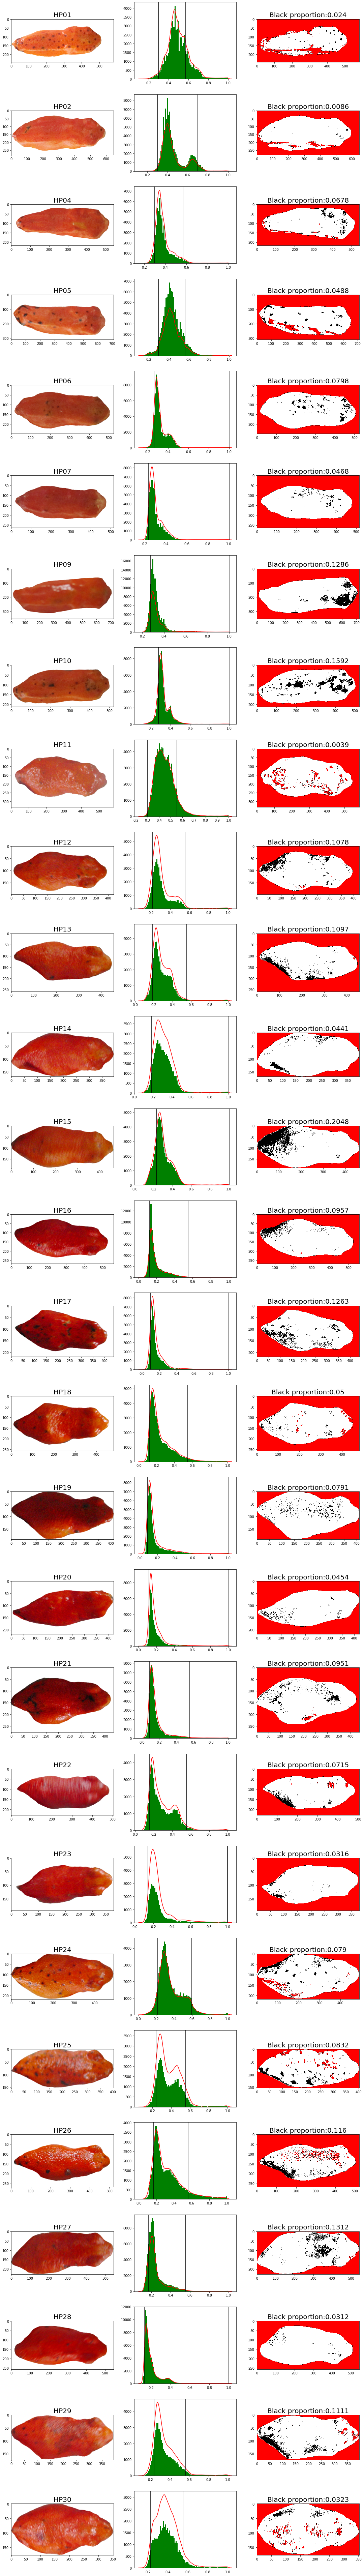

In [16]:
n_frogs=len(ranas)
fig, axs = plt.subplots(n_frogs, 3)
fig.set_size_inches(18.5, n_frogs*5)
cmap = ListedColormap(['red', 'black', 'w'])
for n in range(n_frogs):
    axs[n, 0].imshow(color_original[n], cmap='gray')
    axs[n, 0].set_title(ranas[n],size=20)
    axs[n, 1].hist(original[n].ravel(),bins=80,color="green");
    axs[n, 1].plot(density[n][0],density[n][1]*800,color="red")
    axs[n, 1].axvline(cutoff[n],color="black")
    axs[n, 1].axvline(vglare[n],color="black")
    axs[n, 2].imshow(processed[n],cmap=cmap)
    axs[n, 2].set_title("".join(['Black proportion:',str(round(blackProportion[n],4))]),size=20)

fig.savefig("outputFiles/blackProportionallHPMod.png")

In [19]:
for i in range(0,len(original)):
    img_uint8 = sk.img_as_ubyte(original[i])
    io.imsave("ProcessedImages/Grayscale/"+ranas[i]+"_gray.png",arr=img_uint8)
    io.imsave("ProcessedImages/Binary/"+ranas[i]+"_binary.png",arr=processed[i])

Lossy conversion from int64 to uint8. Range [1, 3]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [1, 3]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [1, 3]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [1, 3]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [1, 3]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [1, 3]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [1, 3]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [1, 3]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [1, 3]. Convert imag

In [20]:
for i in range(0,len(original)):
    hola=(original[i]>cutoff[i]).astype(int)
    io.imsave("ProcessedImages/BinaryGlare/"+ranas[i]+"_binary_glare.png",arr=hola)

Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 1]. Convert imag

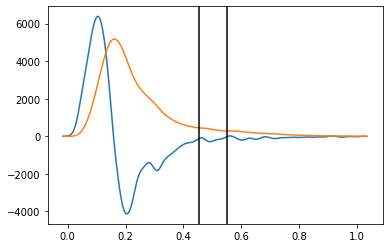

In [175]:
n=10
m=np.diff(density[n][1])/np.diff(density[n][0])
plt.plot(density[n][0][:-1],m*100)
plt.plot(density[n][0],density[n][1]*1000)
plt.axvline(cutoff[n],color="black")
plt.axvline(.55,color="black")


In [131]:
#Write table with results
results=pd.DataFrame([ranas+ranas2,blackProportion+blackProportion2]).T

In [21]:
results=pd.DataFrame([ranas,blackProportion]).T

In [22]:
#So far CM, CL and PP
results.to_csv("outputFiles/thresholdingClassHP.tsv", sep='\t',
               na_rep='', float_format=None, columns=None, header=False,
               index=False, index_label=None, mode='w', encoding=None, compression='infer',
               quoting=None)